# Simons LOI heavy DM sensitivity

<i>Juehang Qin (qin106@purdue.edu), 10 Nov 2022</i>

In this note, I make some sensitivity projections for the simons LOI. To do this, I make a bit of new modularised code that I will commit to the github repository: https://github.com/windchimeproject/windchime-quicksim

In [1]:
# %matplotlib widget
import numpy as np
from scipy import stats

from planckmc.track_generation import halo_model
from planckmc.track_generation import make_tracks

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker
import windchime as chime
import pandas as pd

from numba import njit
from tqdm import tqdm, trange

/depot/darkmatter/etc/conda/env/anacondark/lib/python3.8/site-packages/wimprates/halo.py:143: RuntimeWarning: divide by zero encountered in true_divide
  (v_esc**2 - v_earth_t**2 - v**2)


In [4]:
'''
Just initializes some constants.
'''

## universal constants - https://pdg.lbl.gov/2021/web/viewer.html?file=%2F2020/reviews/rpp2020-rev-phys-constants.pdf
G = 6.64730e-11 #m^3/kg/s^2
amu = 1.6605390666e-27 #kg
k_B = 1.380649e-23 #J/K
GeV_per_c2 = 1.7826619218835431593e-27
v_dm = 220e3 #m/s
rho_dm = 0.3*GeV_per_c2*(100**3) #kg/m^3
# mass_dm = 2.176434e-8 #kg https://en.wikipedia.org/wiki/Planck_units
planck_mass = 2.176434e-8
mass_dm = 1
hbar = 1.054571817e-34
c_light = 299792458

## Windchime experiment class

I define an experiment class to make it easy to experiment with multiple setups. 

In [3]:
class windchime_experiment:
    N_sensors = 2
    length = 0.3 #m
    sensor_mass = 1e-8 #kg
    sensor_density = 1.134e4 #kg/m^3
    resonance_freq = 200/(2*np.pi) #Hz
    sensor_Q = 3e7
    QNR=1
    gas_pressure = 1e-6
    T = 15e-3
    A = 207.2 #Pb
    
    def __init__(self, **kwargs):
        if 'N_sensors' in kwargs:
            self.N_sensors = kwargs['N_sensors']
        if 'sensor_mass' in kwargs:
            self.sensor_mass = kwargs['sensor_mass']
        if 'resonance_freq' in kwargs:
            self.resonance_freq = kwargs['resonance_freq']
        if 'sensor_Q' in kwargs:
            self.sensor_Q = kwargs['sensor_Q']
        if 'QNR' in kwargs:
            self.QNR = kwargs['QNR']
        if 'length' in kwargs:
            self.length = kwargs['length']
        self.A_d = (self.sensor_mass/self.sensor_density)**(2/3)
        self.beta = self.gas_pressure*self.A_d*np.sqrt(4*amu*k_B*self.T)/self.sensor_mass**2

## Limit generation

### Noise model
The noise model follows the basics outlined in [this note](https://www.physics.purdue.edu/darkmatters/doku.php?id=windchime:sensitivity:analytic_sql). The general idea is that the Heisenberg uncertainty from position sensing without any squeezing is:

$$\delta x^2 \geq \frac{\hbar \tau}{m}$$

Where $\tau$ is the measurement time. If we achieve this "standard quantum limit", the force uncertainty is thus:

$$F^2_{SQL} = \frac{4 m \hbar}{\tau^3}$$, and the momentum uncertainty, where $I = F \tau$, would be give by:

$$I^2_{SQL} = \frac{4 m \hbar}{\tau}$$



From this, the total impulse sensitivity can be given by:

$$I^2_{\mathrm{sensitivity}, \tau} = \frac{4 m \hbar}{\tau \xi^2} + \alpha_{\mathrm{thermal}}\tau$$

where $\alpha_{\mathrm{thermal}}$ is the power spectra density of thermal noise, including both from direct coupling to the environment and from brownian motion from residual gas, and $\xi$ is a factor corresponding to the amount of quantum noise reduction where $\xi = 10^{5}$ would correspond to 50dB of quantum noise reduction. This is introduced as a simple model of broadband quantum noise reduction.

In this framework, then, we can find the optimal sensitivity by optimising $\tau$ to give the smallest value of $I^2_{\mathrm{sensitivity}, \tau}$. One would obtain the optimal values of $\tau$, and the smallest $I^2_{\mathrm{sensitivity}, \tau}$, to respectively be:

$$\tau_{\mathrm{optimal}} = \frac{2}{\xi} \sqrt{\frac{\hbar m}{\alpha_{\mathrm{thermal}}}}$$

$$I^2_{\mathrm{sensitivity}, \mathrm{optimal}} = \frac{4}{\xi}\sqrt{\hbar m \alpha_{\mathrm{thermal}}}$$

However, as our signal has a width of $\frac{2b}{v}$, where $b$ is the impact parameter and $v$ is the velocity, $\tau$ cannot be allowed to be lower than that. I use $\frac{2b}{v}$ because it represents an integral from $-\frac{b}{v}$ to $\frac{b}{v}$, which captures $\frac{1}{\sqrt{2}}$ of the signal.

Thus, we can use a piece-wise function to define the noise model:

\begin{equation}
I^2_{\mathrm{sensitivity}} =
\left\{
\begin{array}{ll}
\frac{4}{\xi}\sqrt{\hbar m \alpha_{\mathrm{thermal}}} & \tau_{\mathrm{optimal}} > \frac{2b}{v} \\
\frac{2 m \hbar v}{b \xi^2} + \alpha_{\mathrm{thermal}}\frac{2b}{v} & \tau_{\mathrm{optimal}} \leq \frac{2b}{v}
\end{array}
\right.
\end{equation}

I consider no quantum noise reduction for the proposed work, and 4dB reduction for the next-gen plot.

### Signal
The impulse is simply defined as $$\Delta p = \frac{2 G m_{\mathrm{planck}} m_{\mathrm{sensor}}}{b v}\left(\hat{b} \cdot \hat{n}\right)$$

The $\left(\hat{b} \cdot \hat{n}\right)$ term corresponds to any reduction in the impulse measured due to the alignment between a sensor and the track.

In [8]:
def generate_limits(experiment_setup, N=10000, alpha_bins_edges=np.logspace(-30, -10, 50), mass_dm_bins_edges=np.logspace(-12, -7, 48), sensitivity_toymc_trials=10000, exposure=1, SNR_threshold=10):
    '''
    Exposure in years.
    '''
    
    N_sensors_x = experiment_setup.N_sensors
    N_sensors_y = experiment_setup.N_sensors
    N_sensors_z = experiment_setup.N_sensors
    length_x = length_y = length_z = experiment_setup.length #meter
    spacing = length_x/(N_sensors_x - 1)
    radius = np.max((length_x, length_y, length_z))*2 #metre
    sensor_mass = experiment_setup.sensor_mass
    sensor_density = experiment_setup.sensor_density
    sensor_coords = np.zeros((3, N_sensors_x*N_sensors_y*N_sensors_z))
    coords_1d = (
        np.linspace(-length_x/2, length_x/2, N_sensors_x),
        np.linspace(-length_y/2, length_y/2, N_sensors_y),
        np.linspace(-length_z/2, length_z/2, N_sensors_z),
    )

    x, y, z = np.meshgrid(*coords_1d, indexing='ij')
    
    sensor_coords[0,:] = x.ravel()
    sensor_coords[1,:] = y.ravel()
    sensor_coords[2,:] = z.ravel()

    sensor_vectors = np.repeat([[0,0,1]], sensor_coords.shape[1], axis=0).T #orientation vectors
    min_impact_parameter = (sensor_mass/sensor_density)**(1/3)*np.sqrt(3)/2 #metres
    gas_pressure = 1e-14 #Pa

    A_d = experiment_setup.A_d
    beta = experiment_setup.beta
    sensor_Q = experiment_setup.sensor_Q
    QNR = experiment_setup.QNR
    resonance_freq = experiment_setup.resonance_freq
    
    #make tracks
    vel = halo_model.generate_vel_array(n_vels=N)
    entry_vecs, exit_vecs, t_entry, t_exit = make_tracks.generate_tracks(vel, np.zeros(vel.shape), radius=radius)
    
    velocity = vel
    position_entry = entry_vecs
    position_exit = exit_vecs

    track_parameters = np.vstack((velocity, position_entry, position_exit))
    
    NUMBER_OF_BINS = 10000
    BINS_B = np.logspace(-10, np.log10(np.sqrt(3) * 2 * length_x), NUMBER_OF_BINS)
    BINS_SNR = np.linspace(0, 1e8, NUMBER_OF_BINS)
    
    T = experiment_setup.T
    
    # compute signal strengths
    individual_snrs, individual_b, signal_array, b_array = chime.simulate(track_parameters, sensor_vectors, sensor_coords, sensor_mass, min_impact_parameter, beta, mass_dm=mass_dm, bins_snr=BINS_SNR, bins_b=BINS_B, all_sensor_values = True, signal=chime.signal_without_template_matching, check_assertions=False)
    
    alpha_bins = alpha_bins_edges[:-1] + np.diff(alpha_bins_edges)/2
    mass_dm_bins = mass_dm_bins_edges[:-1] + np.diff(mass_dm_bins_edges)/2
    
    fraction_with_detections = np.zeros((len(mass_dm_bins), len(alpha_bins)))
    
    for i, mass_dm_thisloop in enumerate(tqdm(mass_dm_bins)):
        for j, alpha in enumerate(alpha_bins):
            expected_rate_through_radius = rho_dm*v_dm/mass_dm_thisloop*3600*24*365*np.pi*radius**2 #events per year
            impulse_noise_arr = chime.impulse_noise(b_array, sensor_mass, gas_pressure, A_d, sensor_Q, resonance_freq, T=T, QNR=experiment_setup.QNR)
            SNRs = chime.SNRs_from_S_and_impulse_noise(signal_array, impulse_noise_arr, sensor_mass)/(G*mass_dm*sensor_mass)*(alpha)
            detected = np.sum(SNRs > SNR_threshold)
            pdf_parameters_thisloop = (detected+0.5, N+0.5-detected)
            detected_particles = chime.toy_MC_poisson_detection(expected_rate_through_radius*exposure, pdf_parameters_thisloop, trials=sensitivity_toymc_trials)
            fraction_with_detections[i,j] = np.sum(detected_particles > 0)/sensitivity_toymc_trials

    return (
        [alpha_bins_edges, alpha_bins],
        [mass_dm_bins_edges, mass_dm_bins],
        fraction_with_detections
    )

In [14]:
plt.rcParams.update({
    'font.family': 'serif',
    'figure.dpi': 500,
    'mathtext.fontset': 'dejavuserif',
    'font.size': 10.0
})

In [2]:
def kgtogev(x):
    return x/GeV_per_c2

def gevtokg(x):
    return x*GeV_per_c2

In [ ]:
gen1 = windchime_experiment(length=0.1)
gen2 = windchime_experiment(length=0.1, N_sensors=3)
gen3 = windchime_experiment(length=1, N_sensors=3, sensor_mass=1e-6, QNR=10**4, resonance_freq=20/(2*np.pi))

# gen1 = windchime_experiment(length=1)
# gen2 = windchime_experiment(length=1)
# gen3 = windchime_experiment(length=100)

mass_dm_bins_edges = np.logspace(-13, -7, 91)
# mass_dm_bins_edges = np.logspace(-13, -7, 31)

alpha_bins_edges=np.logspace(-19, -5, 160)
# alpha_bins_edges=np.logspace(-19, -5, 50)

alpha_bin_list, mass_bin_list, fraction_with_detections_g1 = generate_limits(gen1, mass_dm_bins_edges=mass_dm_bins_edges, alpha_bins_edges=alpha_bins_edges, sensitivity_toymc_trials=50000, N=50000)
alpha_bin_list, mass_bin_list, fraction_with_detections_g2 = generate_limits(gen2, mass_dm_bins_edges=mass_dm_bins_edges, alpha_bins_edges=alpha_bins_edges, sensitivity_toymc_trials=50000, N=50000)
alpha_bin_list, mass_bin_list, fraction_with_detections_g3 = generate_limits(gen3, mass_dm_bins_edges=mass_dm_bins_edges, alpha_bins_edges=alpha_bins_edges, sensitivity_toymc_trials=50000, N=50000)

In [ ]:
xenon_limit = pd.read_csv('mass_alpha_xe1t.csv')

In [ ]:
alpha_bins_edges, alpha_bins = alpha_bin_list
mass_dm_bins_edges, mass_dm_bins = mass_bin_list
alpha_grav = G*mass_dm_bins_edges*gen1.sensor_mass

## Coupling definition

The coupling constant, $\alpha$, is defined via the following long-range interaction:

$$F = \frac{\alpha \hbar c N_{\mathrm{nuclei}}}{r^2}$$

For the gravitational interaction, $\alpha_G$ is simply:

$$\alpha_G = \frac{G m_{\chi} m_{\mathrm{nuclei}}}{\hbar c}$$

The $\hbar c$ terms help make $\alpha$ dimensionless.

In [21]:
alpha_grav = G*mass_dm_bins_edges*(amu)/(hbar*c_light)*gen1.A

In [22]:
xenon_limit

,mass_kg,alpha
0,1.782662e-19,6.637544e-04
1,2.392629e-19,6.543026e-04
2,2.882787e-19,6.412195e-04
3,3.902162e-19,6.275450e-04
4,5.249370e-19,6.269894e-04
...,...,...
123,3.457007e-19,3.752409e-09
124,2.846041e-19,3.420163e-09
125,2.417634e-19,3.120630e-09
126,2.148755e-19,2.872347e-09


In [23]:
A_xenon = 131.293
A_gen1 = gen1.sensor_mass/amu
A_gen2 = gen2.sensor_mass/amu
A_gen3 = gen3.sensor_mass/amu

In [25]:
mass_dm_bins_extended_edges = np.logspace(-15, -7, 121)
mass_dm_bins_extended = mass_dm_bins_extended_edges[:-1] + np.diff(mass_dm_bins_extended_edges)/2
alpha_bins_extended_edges = np.logspace(-19, 5, 195)
alpha_bins_extended = alpha_bins_extended_edges[:-1] + np.diff(alpha_bins_extended_edges)/2

fraction_with_detections_g3_extended = np.zeros((120, 194)) + 1
fraction_with_detections_g3_extended[:30, :159] = fraction_with_detections_g3[0]
fraction_with_detections_g3_extended[30:, :159]= fraction_with_detections_g3

fraction_with_detections_g3_extended[:, 159:]= np.repeat(np.array([fraction_with_detections_g3_extended[:, 158]]).T, 35, axis=1)

X_points_extended,Y_points_extended = np.meshgrid(mass_dm_bins_extended, alpha_bins_extended, indexing='ij')

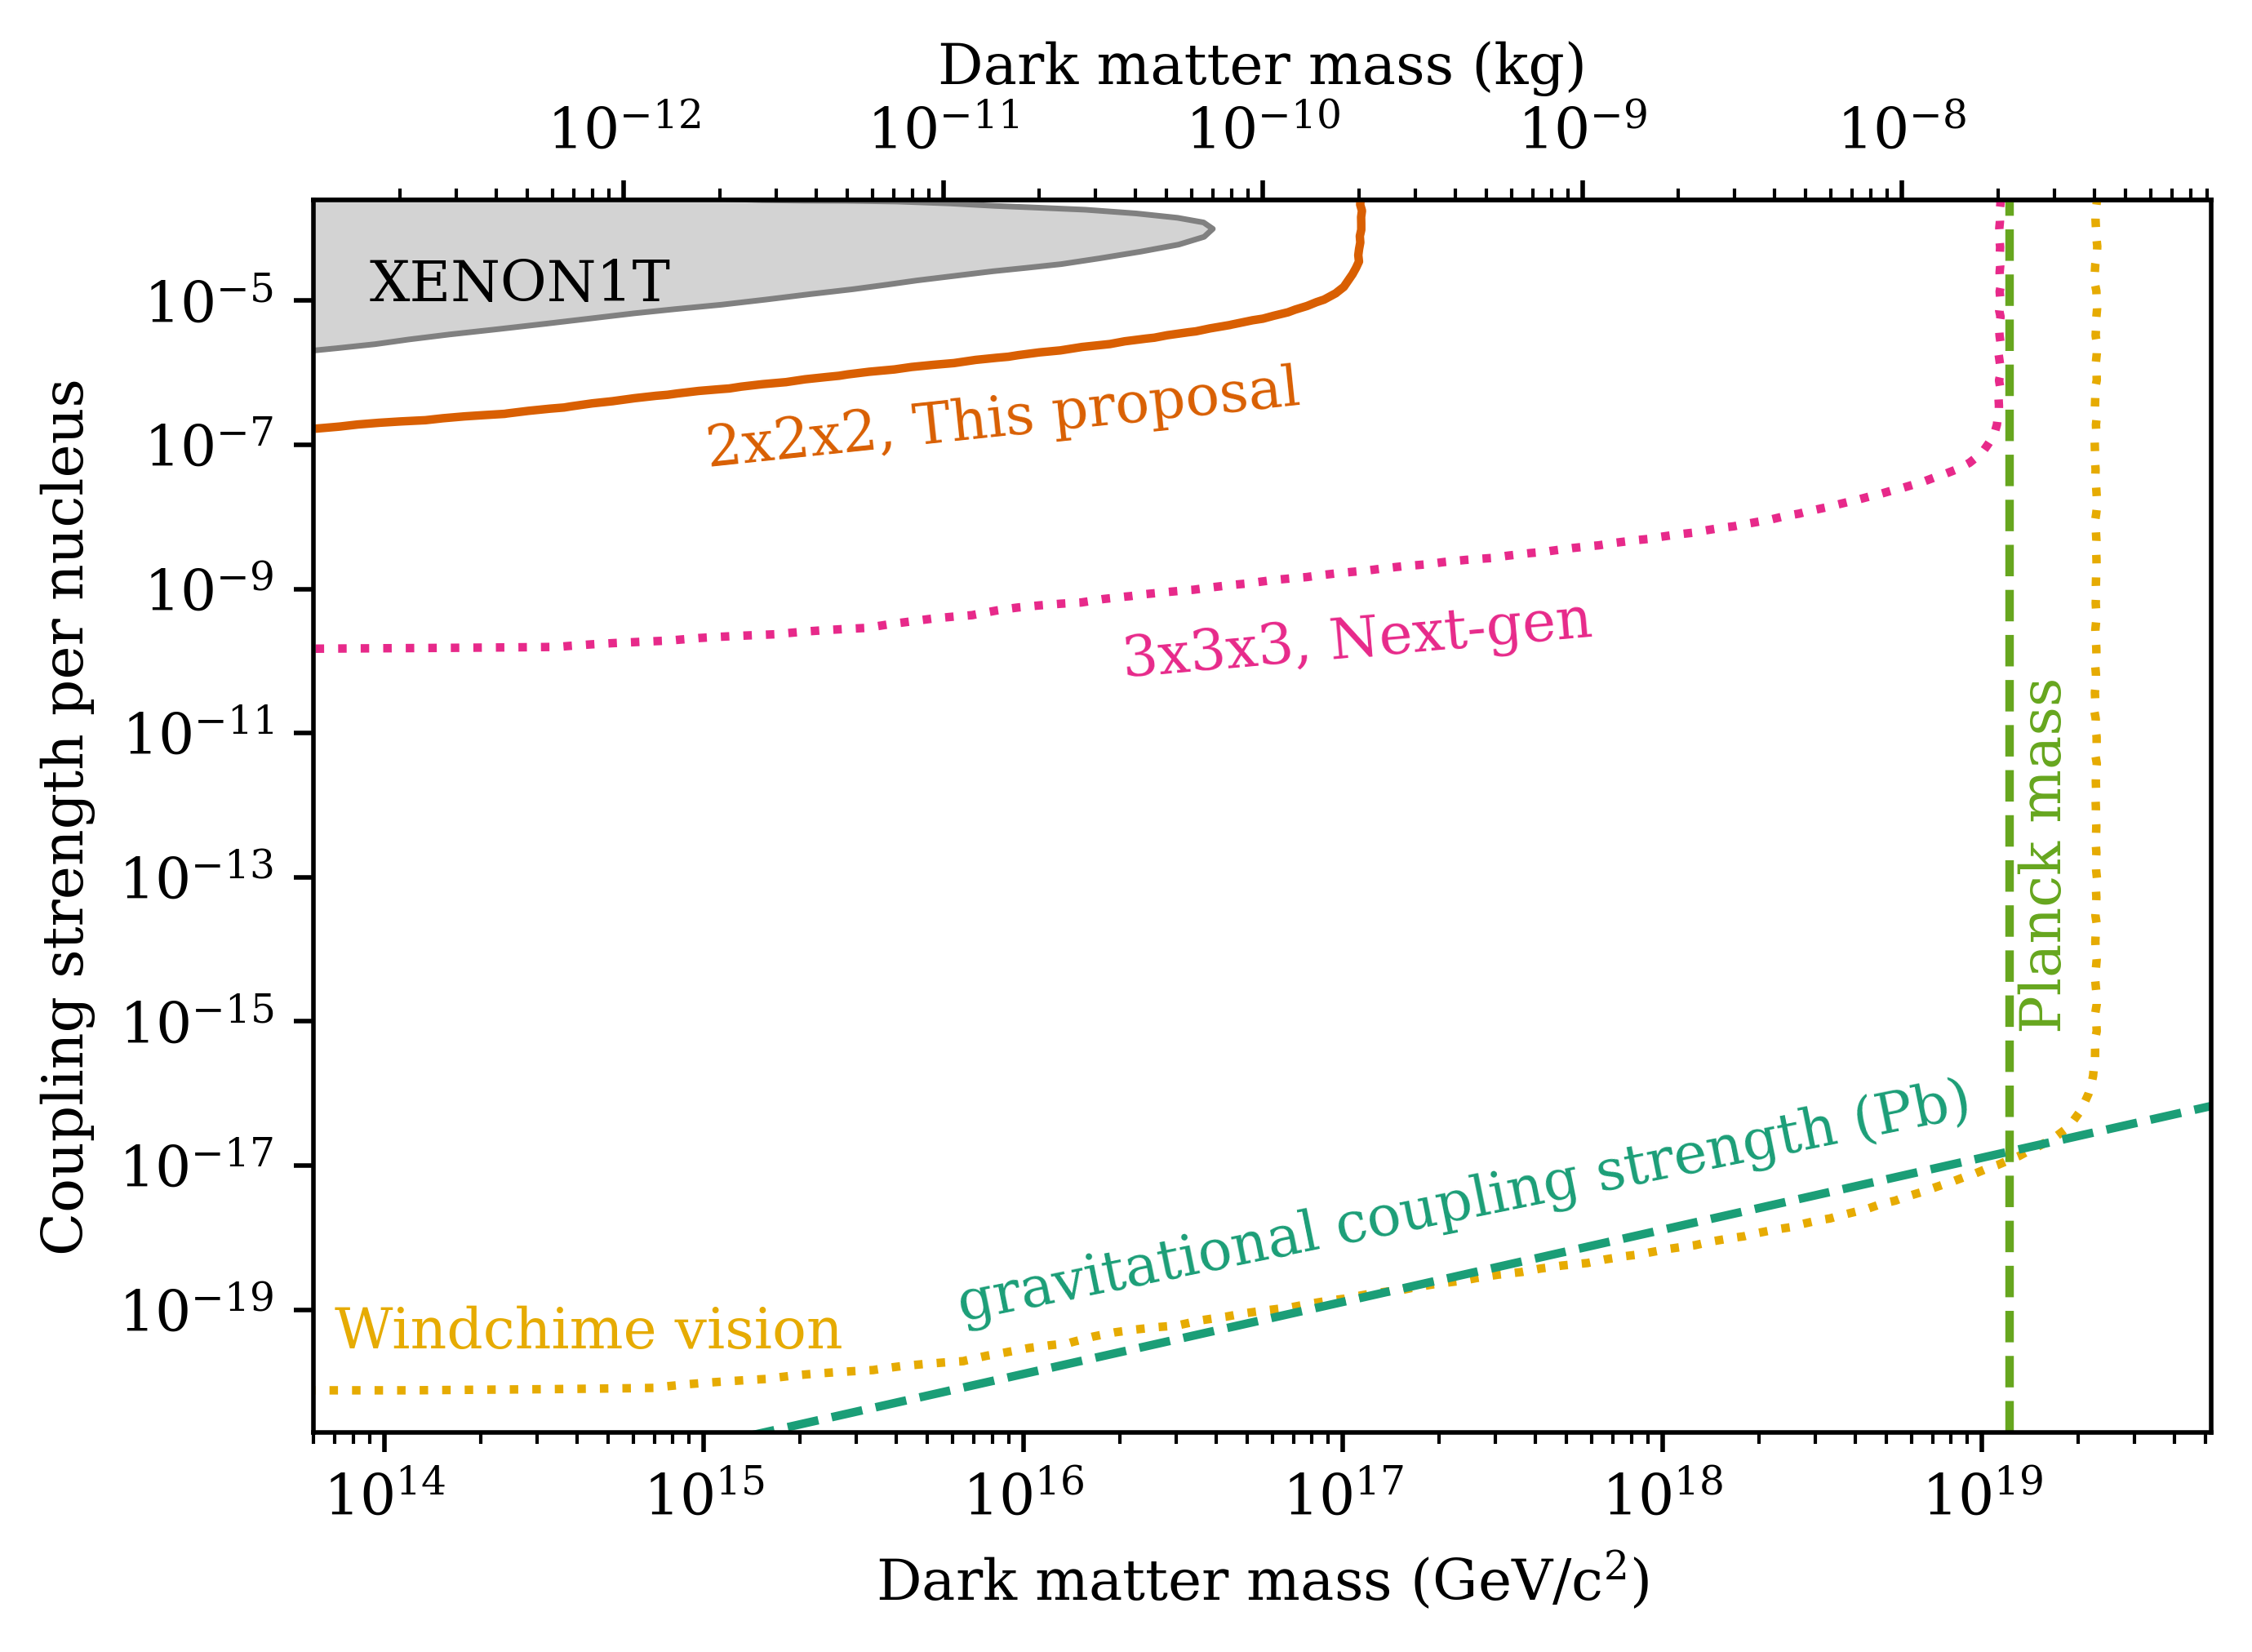

In [28]:
ylim=[2e-21, 2.5e-4]
xlim=[6e13, kgtogev(np.max(mass_dm_bins))]

X,Y = np.meshgrid(mass_dm_bins_edges, alpha_bins_edges, indexing='ij')
X_points,Y_points = np.meshgrid(mass_dm_bins, alpha_bins, indexing='ij')
cmap = cm.get_cmap('magma')
cmap_integer = cm.get_cmap('Dark2')
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
c = ax.contour(kgtogev(X_points), Y_points/(A_gen1*hbar*c_light)*gen1.A, fraction_with_detections_g1, [0.9], colors=[cmap_integer(1)])
ax.text(1e15, 5e-8, '2x2x2, This proposal', rotation=6, color=cmap_integer(1))

# c = ax.contour(kgtogev(X_points), Y_points/(A_gen2*hbar*c_light)*gen2.A, fraction_with_detections_g2, [0.9], colors=[cmap_integer(2)])
# ax.text(3e17, 3e-14, '3x3x3', rotation=0, color=cmap_integer(2))

c = ax.contour(kgtogev(X_points), Y_points/(A_gen3*hbar*c_light)*gen3.A, fraction_with_detections_g3, [0.9], colors=[cmap_integer(3)], linestyles='dotted')
ax.text(2e16, 6e-11, '3x3x3, Next-gen', rotation=5, color=cmap_integer(3))

c = ax.contour(kgtogev(X_points_extended)*2, Y_points_extended/(A_gen3*hbar*c_light)*gen3.A*7e-12, fraction_with_detections_g3_extended, [0.9], colors=[cmap_integer(5)], linestyles='dotted')
ax.text(7e13, 3e-20, 'Windchime vision', rotation=0, color=cmap_integer(5))

ax.plot(kgtogev(mass_dm_bins_edges), alpha_grav, c=cmap_integer(0), linestyle='--')
ax.text(6e15, 7e-20, 'gravitational coupling strength (Pb)', rotation=11.5, c=cmap_integer(0))

ax.vlines(x=[kgtogev(planck_mass)], ymin=ylim[0], ymax=ylim[1], linestyle='--', color=cmap_integer(4))
ax.text(1.3e19, 1e-15, 'Planck mass', rotation=90, c=cmap_integer(4))

secax = ax.secondary_xaxis('top', functions=(gevtokg, kgtogev))
secax.set_xlabel('Dark matter mass (kg)')

# ax.text(1.5e17, 4e-7, 'Fifth force searches', rotation=0, color=(0.5, 0.6, 0.7))
# ax.fill_between(x=kgtogev(mass_dm_bins_edges), y1=1, y2=5e-6, facecolor=(0.7, 0.8, 0.9), edgecolor=(0.5, 0.6, 0.7))

ax.fill_betweenx(x1=kgtogev(xenon_limit['mass_kg'].values), y=xenon_limit['alpha'].values, facecolor='lightgrey', edgecolor='grey')
ax.text(9e13, 1e-5, 'XENON1T', rotation=0, color='k')

ax.set(xlabel=r'Dark matter mass ($\mathrm{GeV/c^2}$)', ylabel='Coupling strength per nucleus', xscale='log', yscale='log', xlim=xlim, ylim=ylim)
# ax.yaxis.set_minor_locator(ticker.LogLocator(base=10))
# ax.yaxis.set_major_locator(ticker.LogLocator(base=10, subs=[1], numticks=30))
ax.minorticks_on()

# ax.yaxis.set_tick_params(which='minor', length=4, color='r', width=1)
# plt.savefig('simons_LOI_sensitivity.pdf'
##             , bbox_inches='tight'
#            )
plt.show()

In [32]:
gen1_heavy = windchime_experiment(length=0.1, sensor_mass=1e-5)
gen2_heavy = windchime_experiment(length=0.1, sensor_mass=1e-5, N_sensors=3)
gen3_heavy = windchime_experiment(length=1, N_sensors=3, sensor_mass=1e-5, QNR=10**4, resonance_freq=20/(2*np.pi))

# # gen1 = windchime_experiment(length=1)
# # gen2 = windchime_experiment(length=1)
# # gen3 = windchime_experiment(length=100)

# mass_dm_bins_edges = np.logspace(-13, -7, 91)
# # mass_dm_bins_edges = np.logspace(-13, -7, 31)

# alpha_bins_edges=np.logspace(-19, -5, 160)
# # alpha_bins_edges=np.logspace(-19, -5, 50)

alpha_bin_list, mass_bin_list, fraction_with_detections_g1_heavy = generate_limits(gen1_heavy, mass_dm_bins_edges=mass_dm_bins_edges, alpha_bins_edges=alpha_bins_edges, sensitivity_toymc_trials=50000, N=50000)
alpha_bin_list, mass_bin_list, fraction_with_detections_g2_heavy = generate_limits(gen2_heavy, mass_dm_bins_edges=mass_dm_bins_edges, alpha_bins_edges=alpha_bins_edges, sensitivity_toymc_trials=50000, N=50000)
alpha_bin_list, mass_bin_list, fraction_with_detections_g3_heavy = generate_limits(gen3_heavy, mass_dm_bins_edges=mass_dm_bins_edges, alpha_bins_edges=alpha_bins_edges, sensitivity_toymc_trials=50000, N=50000)

  0%|          | 0/50000 [00:00<?, ?it/s]/depot/darkmatter/data/jupyterhub/qin/PlanckMass/windchime.py:177: RuntimeWarning: invalid value encountered in sqrt
  snr_result = np.sqrt(signal_result/beta)
100%|██████████| 90/90 [21:08<00:00, 14.09s/it]


In [33]:
A_gen1_heavy = gen1_heavy.sensor_mass/amu
A_gen2_heavy = gen2_heavy.sensor_mass/amu
A_gen3_heavy = gen3_heavy.sensor_mass/amu

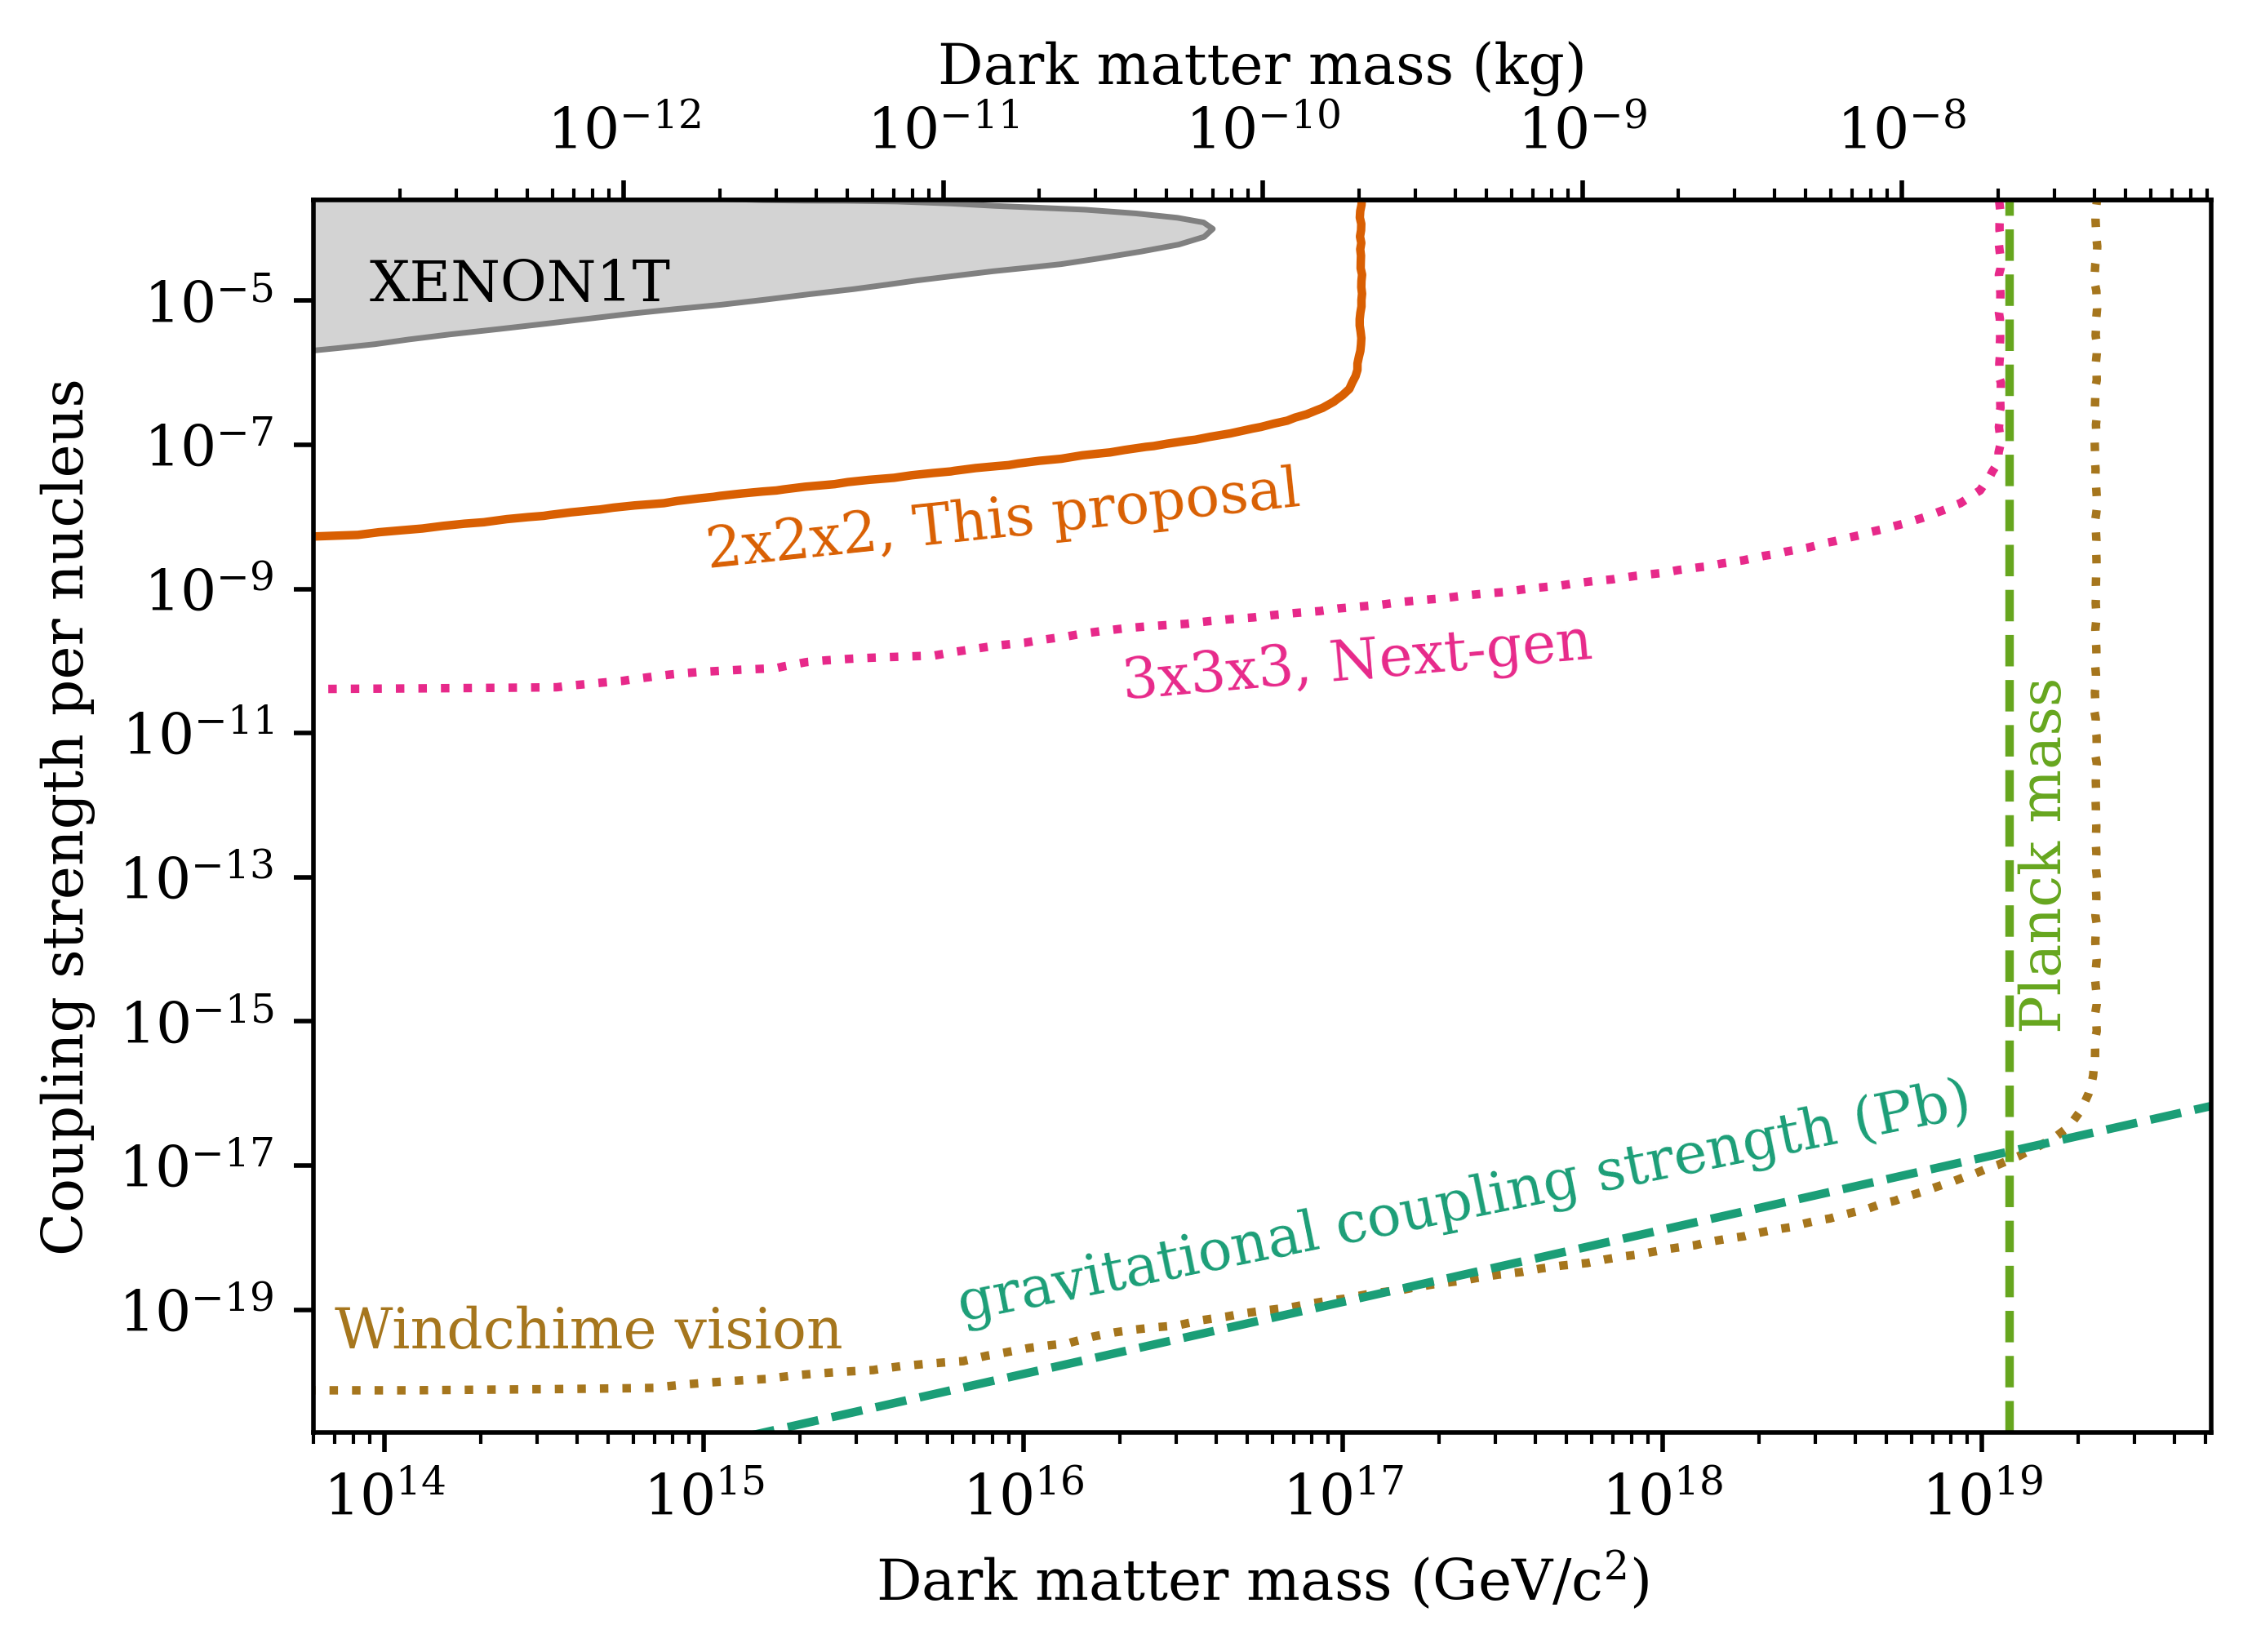

In [34]:
ylim=[2e-21, 2.5e-4]
xlim=[6e13, kgtogev(np.max(mass_dm_bins))]

X,Y = np.meshgrid(mass_dm_bins_edges, alpha_bins_edges, indexing='ij')
X_points,Y_points = np.meshgrid(mass_dm_bins, alpha_bins, indexing='ij')
cmap = cm.get_cmap('magma')
cmap_integer = cm.get_cmap('Dark2')
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
c = ax.contour(kgtogev(X_points), Y_points/(A_gen1_heavy*hbar*c_light)*gen1.A, fraction_with_detections_g1_heavy, [0.9], colors=[cmap_integer(1)])
ax.text(1e15, 2e-9, '2x2x2, This proposal', rotation=6, color=cmap_integer(1))

# c = ax.contour(kgtogev(X_points), Y_points/(A_gen2_heavy*hbar*c_light)*gen2.A, fraction_with_detections_g2, [0.9], colors=[cmap_integer(2)])
# ax.text(3e17, 3e-14, '3x3x3', rotation=0, color=cmap_integer(2))

c = ax.contour(kgtogev(X_points), Y_points/(A_gen3_heavy*hbar*c_light)*gen3.A, fraction_with_detections_g3_heavy, [0.9], colors=[cmap_integer(3)], linestyles='dotted')
ax.text(2e16, 3e-11, '3x3x3, Next-gen', rotation=5, color=cmap_integer(3))

c = ax.contour(kgtogev(X_points_extended)*2, Y_points_extended/(A_gen3*hbar*c_light)*gen3.A*7e-12, fraction_with_detections_g3_extended, [0.9], colors=[cmap_integer(6)], linestyles='dotted')
ax.text(7e13, 3e-20, 'Windchime vision', rotation=0, color=cmap_integer(6))

ax.plot(kgtogev(mass_dm_bins_edges), alpha_grav, c=cmap_integer(0), linestyle='--')
ax.text(6e15, 7e-20, 'gravitational coupling strength (Pb)', rotation=11.5, c=cmap_integer(0))

ax.vlines(x=[kgtogev(planck_mass)], ymin=ylim[0], ymax=ylim[1], linestyle='--', color=cmap_integer(4))
ax.text(1.3e19, 1e-15, 'Planck mass', rotation=90, c=cmap_integer(4))

secax = ax.secondary_xaxis('top', functions=(gevtokg, kgtogev))
secax.set_xlabel('Dark matter mass (kg)')

# ax.text(1.5e17, 4e-7, 'Fifth force searches', rotation=0, color=(0.5, 0.6, 0.7))
# ax.fill_between(x=kgtogev(mass_dm_bins_edges), y1=1, y2=5e-6, facecolor=(0.7, 0.8, 0.9), edgecolor=(0.5, 0.6, 0.7))

ax.fill_betweenx(x1=kgtogev(xenon_limit['mass_kg'].values), y=xenon_limit['alpha'].values, facecolor='lightgrey', edgecolor='grey')
ax.text(9e13, 1e-5, 'XENON1T', rotation=0, color='k')

ax.set(xlabel=r'Dark matter mass ($\mathrm{GeV/c^2}$)', ylabel='Coupling strength per nucleus', xscale='log', yscale='log', xlim=xlim, ylim=ylim)
# ax.yaxis.set_minor_locator(ticker.LogLocator(base=10))
# ax.yaxis.set_major_locator(ticker.LogLocator(base=10, subs=[1], numticks=30))
ax.minorticks_on()

# ax.yaxis.set_tick_params(which='minor', length=4, color='r', width=1)
plt.savefig('simons_LOI_sensitivity.pdf'
#             , bbox_inches='tight'
           )
plt.show()

In [35]:
plt.style.use('dark_background')

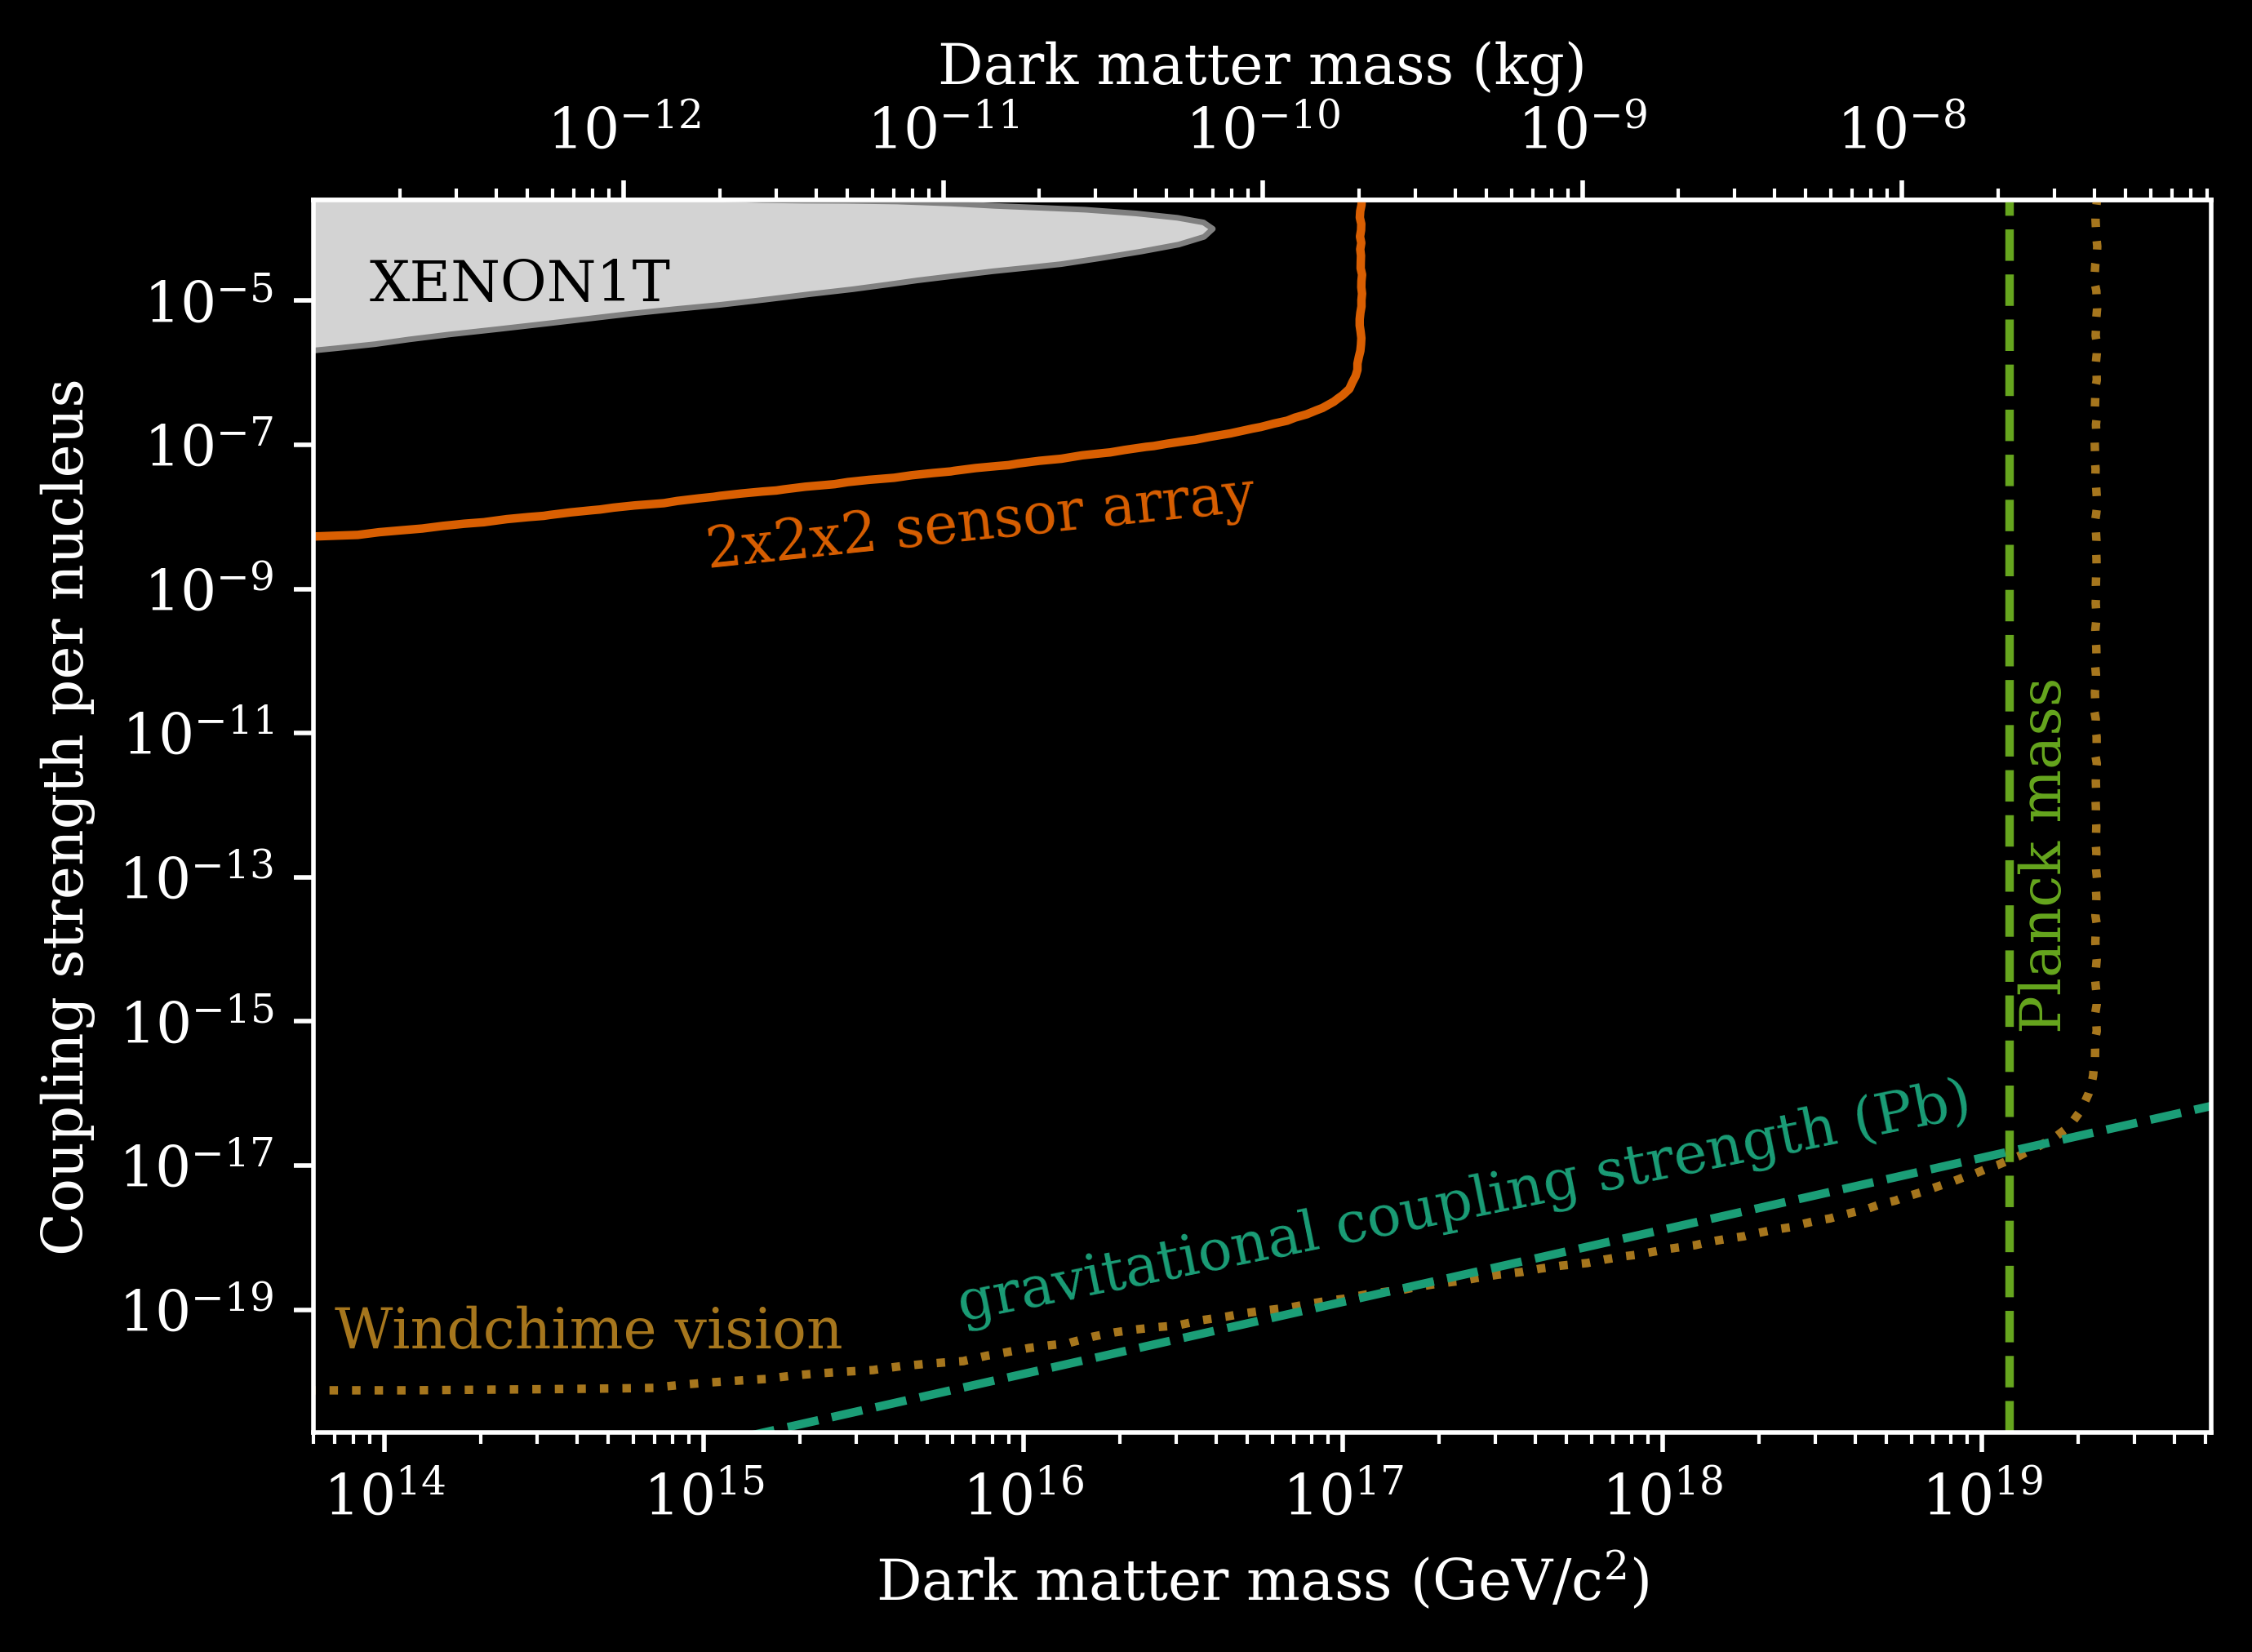

In [38]:
ylim=[2e-21, 2.5e-4]
xlim=[6e13, kgtogev(np.max(mass_dm_bins))]

X,Y = np.meshgrid(mass_dm_bins_edges, alpha_bins_edges, indexing='ij')
X_points,Y_points = np.meshgrid(mass_dm_bins, alpha_bins, indexing='ij')
cmap = cm.get_cmap('magma')
cmap_integer = cm.get_cmap('Dark2')
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
c = ax.contour(kgtogev(X_points), Y_points/(A_gen1_heavy*hbar*c_light)*gen1.A, fraction_with_detections_g1_heavy, [0.9], colors=[cmap_integer(1)])
ax.text(1e15, 2e-9, '2x2x2 sensor array', rotation=6, color=cmap_integer(1))

# c = ax.contour(kgtogev(X_points), Y_points/(A_gen2_heavy*hbar*c_light)*gen2.A, fraction_with_detections_g2, [0.9], colors=[cmap_integer(2)])
# ax.text(3e17, 3e-14, '3x3x3', rotation=0, color=cmap_integer(2))

# c = ax.contour(kgtogev(X_points), Y_points/(A_gen3_heavy*hbar*c_light)*gen3.A, fraction_with_detections_g3_heavy, [0.9], colors=[cmap_integer(3)], linestyles='dotted')
# ax.text(2e16, 3e-11, '3x3x3, Next-gen', rotation=5, color=cmap_integer(3))

c = ax.contour(kgtogev(X_points_extended)*2, Y_points_extended/(A_gen3*hbar*c_light)*gen3.A*7e-12, fraction_with_detections_g3_extended, [0.9], colors=[cmap_integer(6)], linestyles='dotted')
ax.text(7e13, 3e-20, 'Windchime vision', rotation=0, color=cmap_integer(6))

ax.plot(kgtogev(mass_dm_bins_edges), alpha_grav, c=cmap_integer(0), linestyle='--')
ax.text(6e15, 7e-20, 'gravitational coupling strength (Pb)', rotation=11.5, c=cmap_integer(0))

ax.vlines(x=[kgtogev(planck_mass)], ymin=ylim[0], ymax=ylim[1], linestyle='--', color=cmap_integer(4))
ax.text(1.3e19, 1e-15, 'Planck mass', rotation=90, c=cmap_integer(4))

secax = ax.secondary_xaxis('top', functions=(gevtokg, kgtogev))
secax.set_xlabel('Dark matter mass (kg)')

# ax.text(1.5e17, 4e-7, 'Fifth force searches', rotation=0, color=(0.5, 0.6, 0.7))
# ax.fill_between(x=kgtogev(mass_dm_bins_edges), y1=1, y2=5e-6, facecolor=(0.7, 0.8, 0.9), edgecolor=(0.5, 0.6, 0.7))

ax.fill_betweenx(x1=kgtogev(xenon_limit['mass_kg'].values), y=xenon_limit['alpha'].values, facecolor='lightgrey', edgecolor='grey')
ax.text(9e13, 1e-5, 'XENON1T', rotation=0, color='k')

ax.set(xlabel=r'Dark matter mass ($\mathrm{GeV/c^2}$)', ylabel='Coupling strength per nucleus', xscale='log', yscale='log', xlim=xlim, ylim=ylim)
# ax.yaxis.set_minor_locator(ticker.LogLocator(base=10))
# ax.yaxis.set_major_locator(ticker.LogLocator(base=10, subs=[1], numticks=30))
ax.minorticks_on()

# ax.yaxis.set_tick_params(which='minor', length=4, color='r', width=1)
# plt.savefig('simons_LOI_sensitivity.pdf'
#             , bbox_inches='tight'
#            )
plt.show()